In [1]:
# Required imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import boto3
from dotenv import load_dotenv
from scipy import stats
import warnings
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    precision_score,
    recall_score,
    auc,
    f1_score,
    average_precision_score,
)
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import re
from typing import List, Dict



random_state = 55

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

## Get Dataset

In [2]:
FILE_NAME = "feature_frame.csv"
S3_DIR = "groceries/box_builder_dataset/"
BUCKET_NAME = "zrive-ds-data"
S3_PATH = "s3://" + BUCKET_NAME + S3_DIR + FILE_NAME
LOCAL_DATA_PATH = "data/"
LOCAL_FILE_PATH = LOCAL_DATA_PATH + FILE_NAME


def get_data_from_s3():
    """Download data from S3 if not exists locally."""
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    if os.path.exists(LOCAL_FILE_PATH):
        print(f"File already exists at {LOCAL_FILE_PATH}")
        return

    try:
        s3 = boto3.client(
            "s3",
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        )

        key = S3_DIR + FILE_NAME

        print(f"Downloading from {S3_PATH}")
        s3.download_file(BUCKET_NAME, key, LOCAL_FILE_PATH)
        print(f"File downloaded successfully to {LOCAL_FILE_PATH}")

    except Exception as e:
        print(f"Error downloading file: {e}")
        raise


# Download data if needed
get_data_from_s3()

# Load the dataset
df = pd.read_csv(LOCAL_FILE_PATH)

File already exists at data/feature_frame.csv


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
df["outcome"].value_counts(normalize=True)

outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64

It's a very unbalanced dataset.

- Label 1 -> 1.15%
- Label 0 -> 98.85%

## Filtering Data

We should only be focusing on purchases of at least 5 items, since it is a requirement coming from the sales team.

In [6]:
items_bought_per_order = (
    df[df["outcome"] == 1].groupby("order_id").size().reset_index(name="items_bought")
)
# row num diference between df and items_bought_per_order
df_with_count = df.merge(items_bought_per_order, on="order_id", how="left")
df_with_count["items_bought"].fillna(0, inplace=True)

sales_df = df_with_count[df_with_count["items_bought"] > 4]
print(
    f"Deleted items with less than 5 items bought: {len(df_with_count) - len(sales_df)}  ({(len(df_with_count) - len(sales_df))*100/len(df_with_count):.2f}%)"
)

Deleted items with less than 5 items bought: 716596  (24.88%)


## Building linear model

We have the dataset ready for sales team, now, we have to develop a machine learning model that, given a user and a product, predicts if the user would purchase. 

In [7]:
sales_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type', 'items_bought'],
      dtype='object')

So, we have to build a model to predict the 'outcome' feature given the other features:

- User info ->    ```user_order_seq```, ```count_adults```, ```count_children```, ```count_babies```, ```count_pets```, ```people_ex_baby```
- Product info -> ```product_type```, ```normalised_price```, ```discount_pct```, ```vendor```, ```global_popularity```
- Product-User info -> ```ordered_before```, ```abandoned_before```, ```active_snoozed```, ```set_as_regular``` and those related with days since...
- Target -> ```outcome```

What happens with other variables? 

- IDs -> Don`t give numeric information, delete it (```order_id``` will be important to split data, but then, delete it)
- Items_bought -> We won´t have that info in production


We still have 2 variables left: 
1. ```created_at```: In production will be the current date. I will preprocess it and get day num, month num and week num.
2. ```order_date```: Redundant, delete it. 


In [8]:
target = "outcome"
cols_to_drop = ["variant_id", "user_id", "order_date", "items_bought"]
order_id_col = "order_id"

feature_cols = sales_df.columns[~sales_df.columns.isin(cols_to_drop + [target])]

X = sales_df[feature_cols]
y = sales_df[target]
X.shape, y.shape

((2163953, 23), (2163953,))

### Data Split

I'll split the data in three subsets:
1. Train Data -> ~70%
2. Validation data -> ~20%
3. Test data -> ~10%

The key in most supervised learning is how we split the data. 
In this case: 
1. I will not divide products in same order in different data splits, in order to avoid data leakage
2. I will make stratified sampling in order to preserve the target distribution

In [9]:
def split_data(
    X: pd.DataFrame,
    y: pd.Series,
    train_size: int = 0.7,
    val_size: int = 0.2,
    random_state: int = 55,
) -> tuple:

    gss1 = GroupShuffleSplit(
        n_splits=1, train_size=train_size, random_state=random_state
    )
    train_idx, temp_idx = next(gss1.split(X, y, groups=X[order_id_col]))

    X_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx].copy()

    X_temp = X.iloc[temp_idx].copy()
    y_temp = y.iloc[temp_idx].copy()
    groups_temp = X_temp[order_id_col].copy()

    remaining_proportion = 1 - train_size
    val_proportion_of_remaining = val_size / remaining_proportion

    gss2 = GroupShuffleSplit(
        n_splits=1, train_size=val_proportion_of_remaining, random_state=random_state
    )
    val_idx, test_idx = next(gss2.split(X_temp, y_temp, groups=groups_temp))

    X_val = X_temp.iloc[val_idx].copy()
    y_val = y_temp.iloc[val_idx].copy()

    X_test = X_temp.iloc[test_idx].copy()
    y_test = y_temp.iloc[test_idx].copy()

    X_train.drop(columns=[order_id_col], inplace=True)
    X_val.drop(columns=[order_id_col], inplace=True)
    X_test.drop(columns=[order_id_col], inplace=True)

    print(f"Split completed:")
    print(f"  Train ({((len(X_train))*100/(len(X))):.2f}%): {len(X_train)} rows")
    print(f"  Val ({((len(X_val))*100/(len(X))):.2f}%):   {len(X_val)} rows")
    print(f"  Test ({((len(X_test))*100/(len(X))):.2f}%):  {len(X_test)} rows")

    print("\nTarget distribution:")
    print(f"Train outcome distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"Val outcome distribution:\n{y_val.value_counts(normalize=True)}")
    print(f"Test outcome distribution:\n{y_test.value_counts(normalize=True)}")

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X, y, random_state=random_state
)

Split completed:
  Train (69.85%): 1511564 rows
  Val (20.10%):   434859 rows
  Test (10.05%):  217530 rows

Target distribution:
Train outcome distribution:
outcome
0.0    0.985606
1.0    0.014394
Name: proportion, dtype: float64
Val outcome distribution:
outcome
0.0    0.985335
1.0    0.014665
Name: proportion, dtype: float64
Test outcome distribution:
outcome
0.0    0.985312
1.0    0.014688
Name: proportion, dtype: float64


Target distribution is similar inside order_id groups, so I don´t need to take care of this when spliting data

### Data preprocessing

I'll make 2 types of preprocessing:
1. Date preprocesing -> ```created_at```
2. Categorical encoding -> ```vendor``` and ```product_type``` 

**Categorical Encoding**

First of all, I want to know the cardinality of these variables

In [10]:
print(
    f"Vendor cardinality: {len(sales_df['vendor'].unique())}\n"
    f"Product type cardinality: {len(sales_df['product_type'].unique())}"
)

Vendor cardinality: 264
Product type cardinality: 62


So lets see types of encoding and reasons to use or not to use them:

| Encoder | Reason | Choice
| ----------- | ----------- | ----------- |
| **One Hot Encoding** | Cardinality so high |❌​|
| **Dummy Encoding** | Cardinality so high |❌​|
| **Label Encoding** | Better, but model could interpret order relationship when there isn´t |✔️​|
| **Ordinal Encoding** | There is not natural ordering |❌​|
| **Binary Encoding** | Could be, maybe better than label encoding |✔️|
| **Frecuency Encoding** | Could be good option |✔️|
| **Target Encoding** | Good option with high cardinality, but must be used with caution |❓|


------------------

To make things simple, i`ll be working with 2 different encoders, Frecuency & Target

**Date Preprocesing**

```created_at``` feature has this type: **'2020-02-05 16:46:19'**

That isn´t a numeric value, so I will create 6 features from that date:
1. ```year``` (2020)
2. ```month_num``` (02)
3. ```dom``` day of the month (05)
4. ```doy``` day of the year (36)
5. ```woy``` week of the year (05)
5. ```is_weekend``` 0 or 1

In [11]:
categorical_columns = ["product_type", "vendor"]
date_column = "created_at"

class DateFeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, date_column="created_at"):
        self.date_column = date_column

    def process_date(self, input_str: str) -> dict:
        date_str = input_str.split(" ")[0]

        regex = re.compile(r"\d{4}-\d{2}-\d{2}")
        if not re.match(regex, date_str):
            return {}

        my_date = datetime.strptime(date_str, "%Y-%m-%d").date()
        date_feats = {}

        date_feats["year"] = int(my_date.strftime("%Y"))
        date_feats["month_num"] = int(my_date.strftime("%m"))
        date_feats["dom"] = int(my_date.strftime("%d"))
        date_feats["doy"] = int(my_date.strftime("%j"))
        date_feats["woy"] = int(my_date.strftime("%W"))

        # Fixing day of week to start on Mon (1), end on Sun (7)
        dow = my_date.strftime("%w")
        if dow == "0":
            dow = 7
        date_feats["dow_num"] = int(dow)

        date_feats["is_weekend"] = 1 if int(dow) > 5 else 0

        return date_feats

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        date_features = []
        for date_value in X_copy[self.date_column]:
            date_features.append(self.process_date(date_value))

        date_df = pd.DataFrame(date_features, index=X_copy.index)

        X_transformed = pd.concat([X_copy, date_df], axis=1)

        X_transformed = X_transformed.drop(columns=[self.date_column])

        return X_transformed


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.frequency_maps = {}

    def fit(self, X, y=None):
        for column in self.categorical_columns:
            if column in X.columns:
                frequencies = X[column].value_counts(normalize=True).to_dict()
                self.frequency_maps[column] = frequencies
        return self

    def transform(self, X):
        X_copy = X.copy()

        for column in self.categorical_columns:
            if column in X_copy.columns:
                default_value = (
                    min(self.frequency_maps[column].values())
                    if self.frequency_maps[column]
                    else 0
                )
                X_copy[column] = X_copy[column].map(
                    lambda x: self.frequency_maps[column].get(x, default_value)
                )

        return X_copy


class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        categorical_columns,
        target_column="outcome",
        min_samples_leaf=1,
        smoothing=1.0,
    ):
        self.categorical_columns = categorical_columns
        self.target_column = target_column
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = smoothing
        self.target_means = {}
        self.global_mean = 0

    def fit(self, X, y=None):

        self.global_mean = y.mean()

        if len(X) != len(y):
            raise ValueError("X and y must have the same number of rows")

        for column in self.categorical_columns:
            if column in X.columns:
                temp_df = pd.DataFrame({
                    'category': X[column],
                    'target': y
                })
                agg_df = temp_df.groupby('category').agg({
                    'target': ['count', 'mean']
                })
                agg_df.columns = ['count', 'mean']
                agg_df['smooth_mean'] = (
                    (agg_df['count'] * agg_df['mean'] + self.smoothing * self.global_mean) /
                    (agg_df['count'] + self.smoothing)
                )

                self.target_means[column] = agg_df['smooth_mean'].to_dict()

        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.categorical_columns:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].map(
                    lambda x: self.target_means[column].get(x, self.global_mean)
                )
        
        return X_copy


In [12]:
frequency_encoding_pipeline = Pipeline(
    [
        ("date_transformer", DateFeatureTransformer(date_column=date_column)),
        (
            "frequency_encoder",
            FrequencyEncoder(categorical_columns=categorical_columns),
        ),
    ]
)

target_encoding_pipeline = Pipeline(
    [
        ("date_transformer", DateFeatureTransformer(date_column=date_column)),
        (
            "target_encoder",
            TargetEncoder(
                categorical_columns=categorical_columns, target_column="outcome"
            ),
        ),
    ]
)

### Model Selection

Now, it`s time to create different pipelines and choose the best prediction validation data. We can crete different models conbining:
- Preprocesor
- ML Model
- Hiperparameters of the model:
    - Regularization
    - Class Weight
    - Classification Threshold

I won`t give so much attention to regularization, because I consider data is big enough. But i´m going to try with some L2 and differents regularization strength values.

Class Weight seems to be important, because we are with a imbalanced dataset. ```class_weight``` allows us to assign higher weights to the minority class and lower weights to the majority class. The model will prioritize reducing errors for the minority class.

In order to adjust the optimal classification threshold for each model, I'll calculate with ROC Curve and Precision-Recall curve. 

### **Selecting the Optimal Threshold for Push Notifications**

For our customer purchase prediction model, we need to carefully consider several factors:

1. **Current baseline performance**: Push notifications in our app have only a 5% open rate, only 1 of 20 users open them.

2. **False positive impact**: Sending irrelevant notifications is particularly costly given that:
   - Users already ignore 95% of notifications
   - Each irrelevant notification increases notification fatigue
   - This may further reduce engagement with future notifications

3. **Optimization strategy**: Given these constraints, we should:
   - Prioritize high precision over high recall
   - Only send notifications when we have high confidence in purchase intent
   - Consider the user's notification history and engagement patterns

This approach ensures we maintain notification quality and preserve this engagement channel's effectiveness for truly valuable opportunities.

I'll have these pipelines: 

| Name | Encoder | Model | Penalty | Class Weight
| ----------- | ----------- | ----------- | ----------- | ----------- |
| **First Pipeline** | Frecuency |LogisticRegression​|None|Balanced|
| **Second Pipeline** | Target |LogisticRegression​|None|Balanced|
| **Third Pipeline** | Frecuency |LogisticRegression​|L2 (c=1)|1/10|
| **Fourth Pipeline** | Target |LogisticRegression|L2 (c=0.6)|1/10|
| **Fifth Pipeline** | Frecuency |LogisticRegression|L2 (c=1)|Balanced|
| **Sixth Pipeline** | Target |LogisticRegression|None|1/5|
| **Seventh Pipeline** | Frecuency |RandomForest|-|Balanced|

The random forest is only to compare linear to non-linear models


In [13]:
first_pipeline = Pipeline(
    [
        ("preprocessor", frequency_encoding_pipeline),
        ("classifier",
            LogisticRegression(
                penalty=None,
                class_weight='balanced',
                max_iter=1000,
                random_state=random_state,
            ),
        ),
    ]
)

second_pipeline = Pipeline(
    [
        ("preprocessor", target_encoding_pipeline),
        ("classifier",
            LogisticRegression(
                penalty=None,
                class_weight='balanced',
                max_iter=1000,
                random_state=random_state,
            ),
        ),
    ]
)

third_pipeline = Pipeline(
    [
        ("preprocessor", frequency_encoding_pipeline),
        ("classifier",
            LogisticRegression(
                penalty="l2",
                C=1,
                class_weight={0: 1, 1: 10},
                max_iter=1000,
                random_state=random_state,
            ),
        ),
    ]
)

fourth_pipeline = Pipeline(
    [
        ("preprocessor", target_encoding_pipeline),
        ("classifier",
            LogisticRegression(
                penalty="l2",
                C=0.6,
                class_weight={0: 1, 1: 10},
                max_iter=1000,
                random_state=random_state,
            ),
        ),
    ]
)

fifth_pipeline = Pipeline(
    [
        ("preprocessor", frequency_encoding_pipeline),
        ("classifier",
            LogisticRegression(
                penalty="l2",
                C=1,
                class_weight="balanced",
                max_iter=1000,
                random_state=random_state,
            ),
        ),
    ]
)

sixth_pipeline = Pipeline(
    [
        ("preprocessor", target_encoding_pipeline),
        ("classifier",
            LogisticRegression(
                penalty=None,
                class_weight={0: 1, 1: 5},
                max_iter=1000,
                random_state=random_state,
            ),
        ),
    ]
)

seventh_pipeline = Pipeline(
    [
        ("preprocessor", frequency_encoding_pipeline),
        (
            "classifier",
            RandomForestClassifier(
                n_estimators=100,
                max_depth=5,
                min_samples_leaf=10,
                class_weight="balanced",
                random_state=random_state,
            ),
        ),
    ]
)

pipelines = [first_pipeline, second_pipeline, third_pipeline,
            fourth_pipeline, fifth_pipeline, sixth_pipeline, seventh_pipeline]
pipeline_names = [
    "Frequency Encoding (No Penalty)",
    "Target Encoding (No Penalty)",
    "Frequency Encoding (L2 Penalty)",
    "Target Encoding (L2 Penalty)",
    "Frequency Encoding (L2 Penalty, Balanced)",
    "Target Encoding (No Penalty, Class Weight)",
    "Random Forest (Frequency Encoding)"
]

Here i have defined functions to get the best threshold (optimizing precision) and and function to do this process for each pipeline, then, I will choose with which one I will get


Training pipeline 1/7: Frequency Encoding (No Penalty)


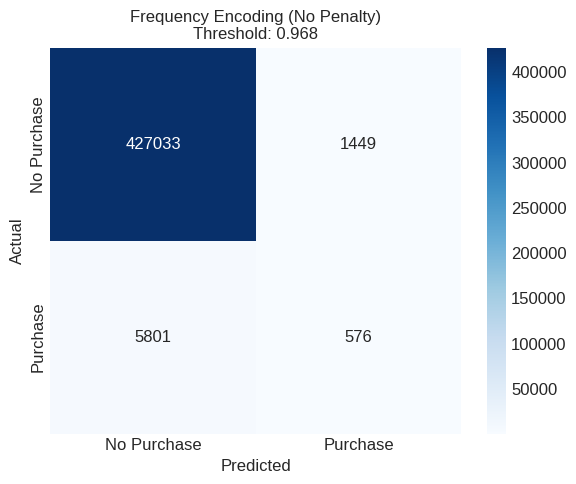


Training pipeline 2/7: Target Encoding (No Penalty)


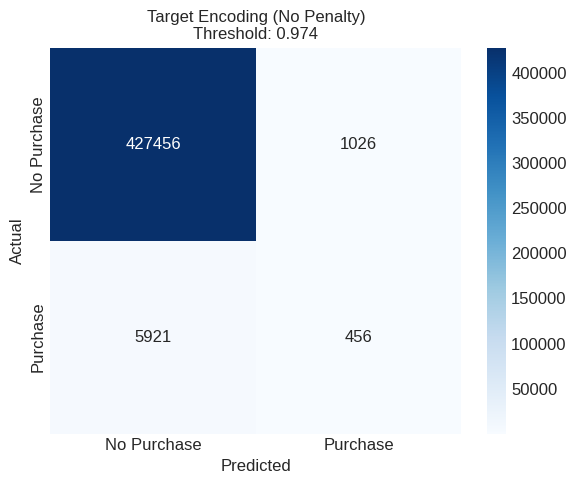


Training pipeline 3/7: Frequency Encoding (L2 Penalty)


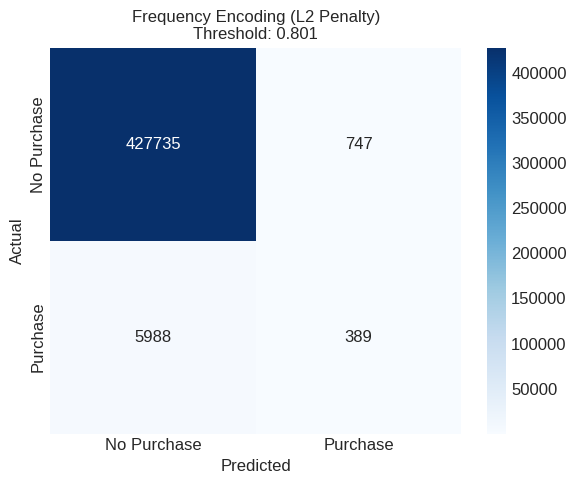


Training pipeline 4/7: Target Encoding (L2 Penalty)


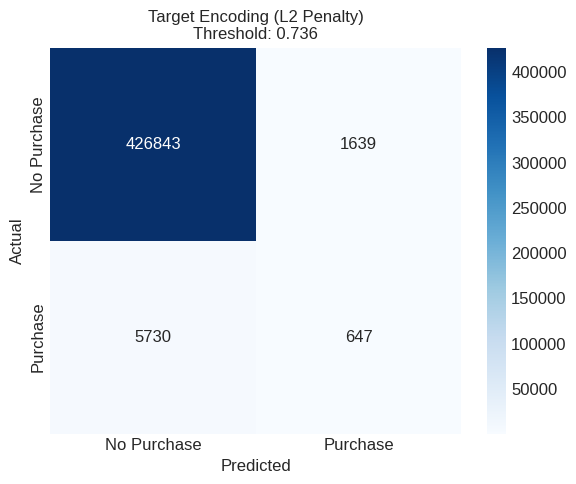


Training pipeline 5/7: Frequency Encoding (L2 Penalty, Balanced)


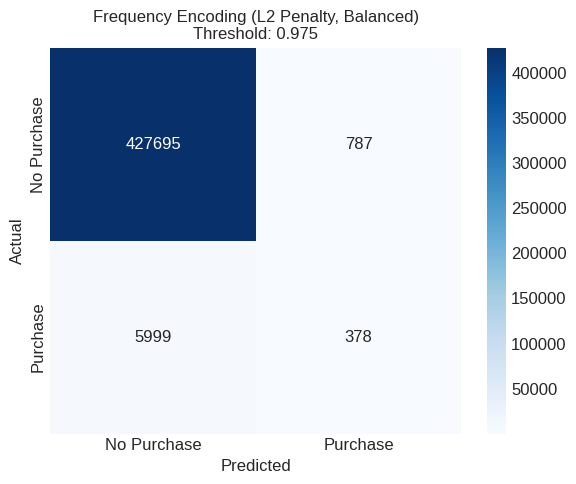


Training pipeline 6/7: Target Encoding (No Penalty, Class Weight)


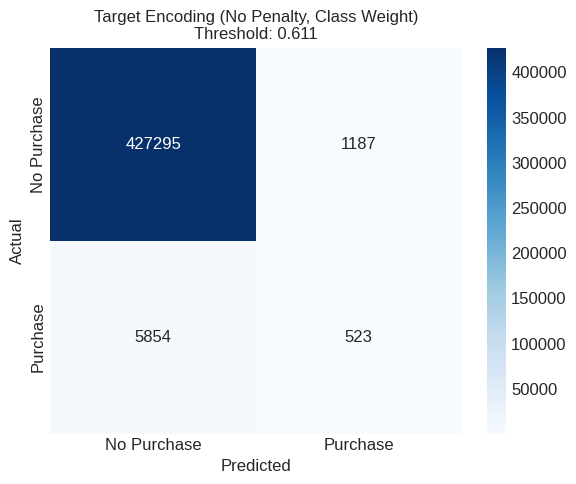


Training pipeline 7/7: Random Forest (Frequency Encoding)


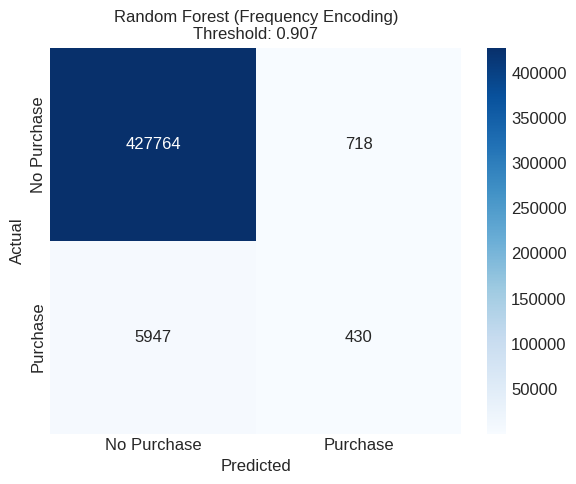

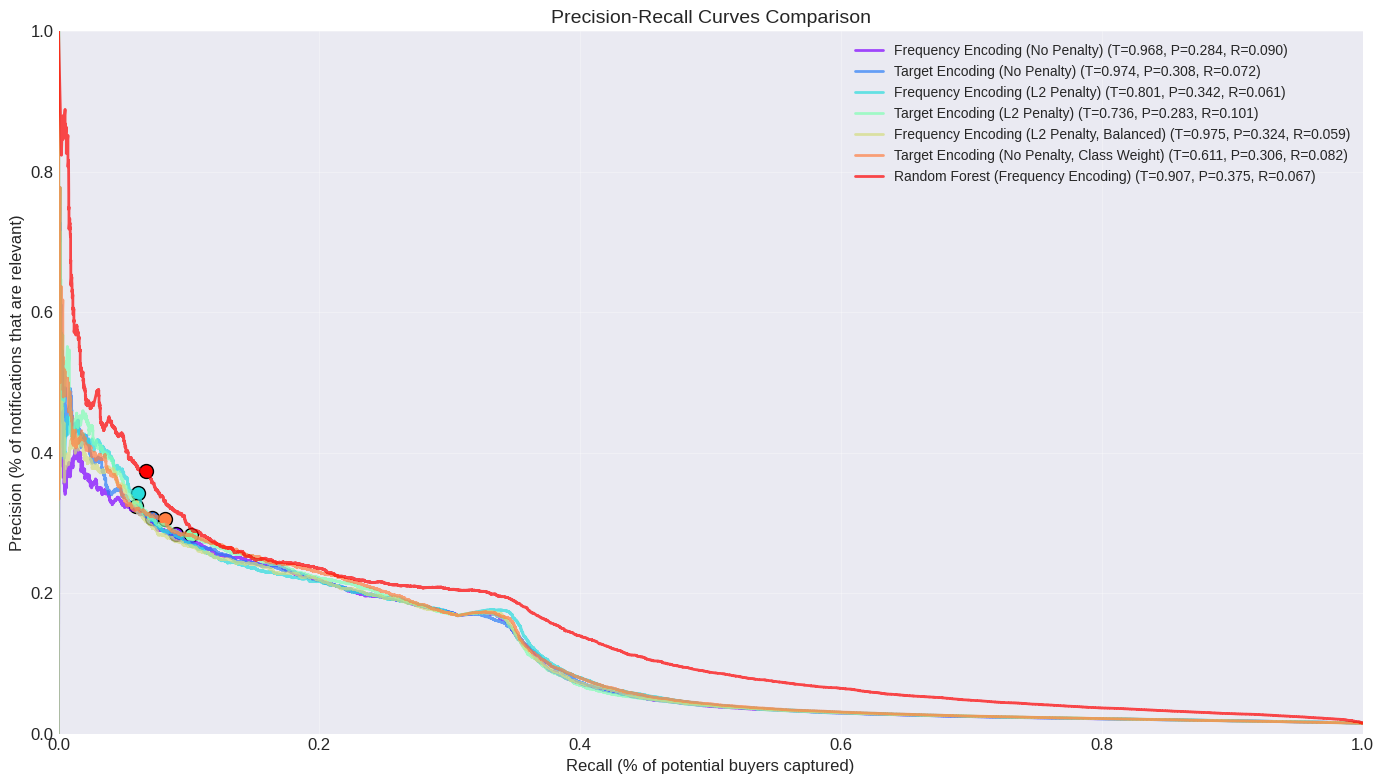


FINAL COMPARISON:
                                  Pipeline  Threshold     F0.3  Precision   Recall  Notification Rate
        Random Forest (Frequency Encoding)   0.906630 0.272195   0.374564 0.067430           0.002640
Target Encoding (No Penalty, Class Weight)   0.610839 0.249600   0.305848 0.082013           0.003932
           Frequency Encoding (L2 Penalty)   0.800517 0.247969   0.342430 0.061000           0.002612
              Target Encoding (L2 Penalty)   0.736316 0.246590   0.283027 0.101458           0.005257
              Target Encoding (No Penalty)   0.973722 0.241759   0.307692 0.071507           0.003408
           Frequency Encoding (No Penalty)   0.968117 0.241576   0.284444 0.090325           0.004657
 Frequency Encoding (L2 Penalty, Balanced)   0.974865 0.236939   0.324464 0.059276           0.002679


In [14]:
def evaluate_pipeline(
    pipeline, X_val, y_val, beta: float = 0.3
) -> Dict:
    """
    Evaluate a pipeline and find the optimal threshold based on F-beta score.
    """
    y_val_proba = pipeline.predict_proba(X_val)[:, 1]
    
    precision, recall, thresholds_pr = precision_recall_curve(y_val, y_val_proba)
    
    # Find optimal threshold using F-beta score
    f_beta_scores = ((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall + 1e-10)
    best_idx = np.argmax(f_beta_scores)
    best_threshold = thresholds_pr[best_idx] if best_idx < len(thresholds_pr) else 0
    best_f_beta = f_beta_scores[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    
    y_pred = (y_val_proba >= best_threshold).astype(int)
    
    cm = confusion_matrix(y_val, y_pred)
    
    notification_rate = y_pred.mean()
    
    results = {
        'name': pipeline.steps[-1][0],
        'threshold': best_threshold,
        'f_beta': best_f_beta,
        'precision': best_precision,
        'recall': best_recall,
        'confusion_matrix': cm,
        'notification_rate': notification_rate,
        'curves': {
            'precision': precision,
            'recall': recall,
            'thresholds_pr': thresholds_pr,
        },
        'y_val_proba': y_val_proba,
    }
    
    return results

def plot_confusion_matrix(
        results: Dict, pipeline_name: str
    ) -> None:

    cm = results['confusion_matrix']
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['No Purchase', 'Purchase'],
        yticklabels=['No Purchase', 'Purchase']
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{pipeline_name}\nThreshold: {results["threshold"]:.3f}', fontsize=12)
    plt.tight_layout()
    plt.show()

def compare_pipelines_pr_curves(all_results: List[Dict], pipeline_names: List[str]) -> None:
    """Create one PR curve with all pipelines plotted together."""
    plt.figure(figsize=(14, 8))
    
    # Use a color map to have distinct colors for each pipeline
    colors = cm.rainbow(np.linspace(0, 1, len(all_results)))
    
    for i, (results, name) in enumerate(zip(all_results, pipeline_names)):
        color = colors[i]
        
        # Plot PR curve
        plt.plot(
            results['curves']['recall'],
            results['curves']['precision'],
            linewidth=2,
            alpha=0.7,
            color=color,
            label=f"{name} (T={results['threshold']:.3f}, P={results['precision']:.3f}, R={results['recall']:.3f})"
        )
        
        # Plot the optimal threshold point
        plt.scatter(
            results['recall'],
            results['precision'],
            color=color,
            marker='o',
            s=100,
            edgecolors='black'
        )
    
    # Add grid, labels, title and legend
    plt.grid(True, alpha=0.3)
    plt.xlabel('Recall (% of potential buyers captured)', fontsize=12)
    plt.ylabel('Precision (% of notifications that are relevant)', fontsize=12)
    plt.title('Precision-Recall Curves Comparison', fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def compare_pipelines(
    pipelines: List, pipeline_names: List[str], 
    X_train, y_train, X_val, y_val, beta: float = 0.3
) -> pd.DataFrame:
    """
    Shows confusion matrices and a combined PR curve.
    """
    assert len(pipelines) == len(pipeline_names), "Number of pipelines must match number of names"
    
    results_list = []
    all_evaluation_results = []
    
    for i, (pipeline, name) in enumerate(zip(pipelines, pipeline_names)):
        print(f"\nTraining pipeline {i+1}/{len(pipelines)}: {name}")
        pipeline.fit(X_train, y_train)
        
        eval_results = evaluate_pipeline(pipeline, X_val, y_val, beta)
        all_evaluation_results.append(eval_results)
        
        plot_confusion_matrix(eval_results, name)
        
        results_list.append({
            'Pipeline': name,
            'Threshold': eval_results['threshold'],
            f'F{beta}': eval_results['f_beta'],
            'Precision': eval_results['precision'],
            'Recall': eval_results['recall'],
            'Notification Rate': eval_results['notification_rate'],
        })
    
    comparison_df = pd.DataFrame(results_list).sort_values(by=f'F{beta}', ascending=False)
    
    compare_pipelines_pr_curves(all_evaluation_results, pipeline_names)
    
    return comparison_df

comparison = compare_pipelines(
    pipelines, 
    pipeline_names, 
    X_train, y_train,
    X_val, y_val, 
    beta=0.3
)

print("\nFINAL COMPARISON:")
print(comparison.to_string(index=False))

# Model Selection for Purchase Prediction

## Analysis of Model Performance

After comparing different models for predicting purchase behavior, we need to select the most appropriate linear model for our business case. The key considerations are:

1. **High precision** to ensure we minimize irrelevant notifications
2. **Reasonable recall** to capture a meaningful portion of potential buyers
3. **Appropriate notification rate** that balances reach with relevance

## Evaluating Linear Models

While the Random Forest model showed superior performance, our requirement for a linear model narrows our focus to the logistic regression variants. Among these:

**Target Encoding (No Penalty, Class Weight 1/5)** emerged as the strongest performer:
- Highest F0.3 score (0.250) among linear models
- Good precision (0.306) with the second-highest recall (0.082)
- Reasonable notification rate (0.393%), striking a balance between reach and precision

The other linear models either had lower precision, insufficient recall, or suboptimal F-beta scores.

## Final Recommendation

For this specific business problem:

**I will choose the Target Encoding (No Penalty, Class Weight 1/5) model** 

In [21]:
import joblib
DIR = "models/"
os.makedirs(DIR, exist_ok=True)
FILE_NAME = "classification_pipeline.pkl"
THRESHOLD = 0.610839

In [ ]:
best_pipeline = pipelines[5]
joblib.dump(best_pipeline, DIR + FILE_NAME)

with open('models/optimal_threshold.txt', 'w') as f:
    f.write(str(THRESHOLD))

Load the model and it´s threshold, then train the model with train data and validation data

In [24]:
pipeline = joblib.load(DIR + FILE_NAME)

with open('models/optimal_threshold.txt', 'r') as f:
    optimal_threshold = float(f.read().strip())

X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

pipeline.fit(X_train_val, y_train_val)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('date_transformer', DateFeatureTransformer()),
                                 ('target_encoder',
                                  TargetEncoder(categorical_columns=['product_type',
                                                                     'vendor']))])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000,
                                    penalty=None, random_state=55))])

Finally let`s see the performance in test dataset, we musn´t take into account this results for nothing. I would be manual overfiting!

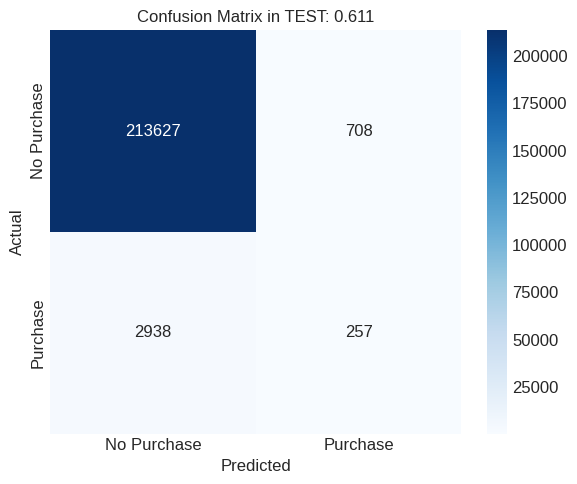

In [25]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= THRESHOLD).astype(int)

# Plot confusión matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Purchase', 'Purchase'],
    yticklabels=['No Purchase', 'Purchase']
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix in TEST: {THRESHOLD:.3f}', fontsize=12)
plt.tight_layout()
plt.show()

- 965 push notifications sent
- 257 will buy
- Only 12 of them will open the notification
- There where 2938 buyers without receiving notification

